# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [37]:
import numpy as np
import pandas as pd
import math
import seaborn as sns


import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors as neigh
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from IPython.display import display
from sklearn.utils import shuffle

#ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2927,0,41.0,33800.0,2,0
4797,1,29.0,36600.0,2,0
3288,1,24.0,44300.0,2,0
1168,1,31.0,38600.0,0,0
2813,1,28.0,39400.0,1,0
2967,0,27.0,34700.0,0,0
2192,0,25.0,46200.0,0,0
703,1,30.0,41700.0,2,0
3188,1,30.0,52600.0,2,0
1022,0,21.0,45800.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical
df['age'] = df['age'].astype('int32')

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int32
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


As we don't have any unique identifier, we will assume that there are no duplicated row because this is reasonable that some records will have the same values. 

In [10]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


There are no missing values, and the range of the values seem to be reasonable and it doesn't seem to have any extreme values. Now we'll need to see the distributions of the features. (It is not clear what is the encoding of the gender but for now it's not relevant as long as it is balanced).

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

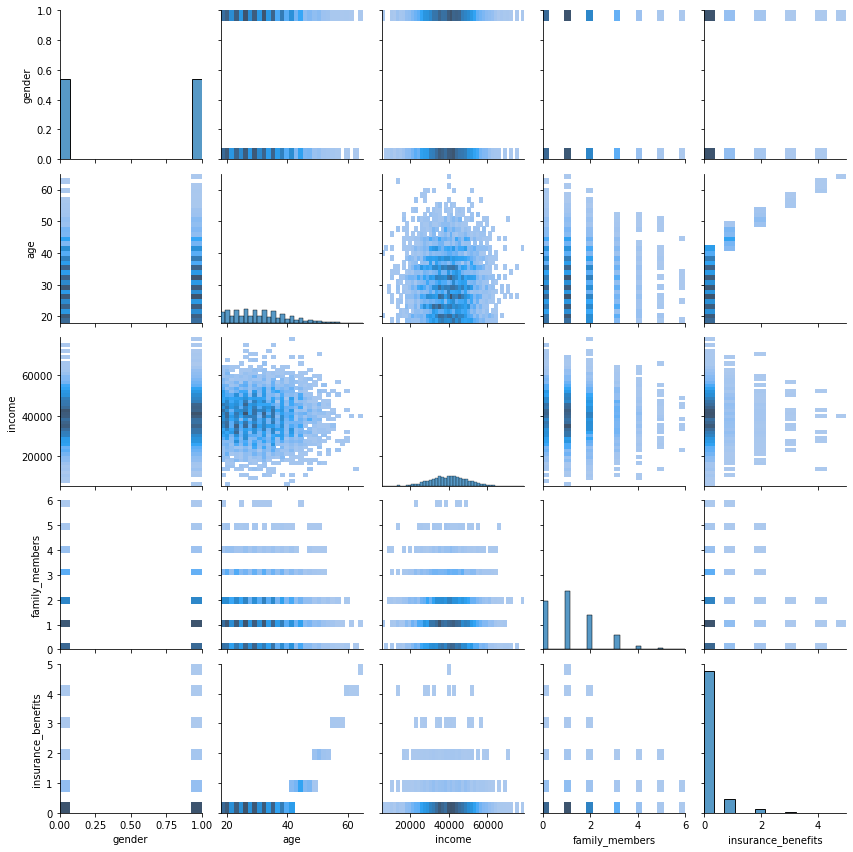

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = neigh.NearestNeighbors(n_neighbors = k, metric = metric) 
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1017,1.0,0.353846,0.492405,0.833333,0
1872,1.0,0.415385,0.551899,0.166667,0
3537,0.0,0.292308,0.373418,0.166667,0
1863,0.0,0.707692,0.492405,0.166667,1
4122,1.0,0.430769,0.559494,0.000000,0


Now, let's get similar records for a given one for every combination

In [16]:
get_knn(df, 50, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
50,1,28,39600.0,0,0,0.000000
3766,1,29,39600.0,0,0,1.000000
1547,0,21,39600.0,0,0,7.071068
2930,0,21,39600.0,3,0,7.681146
270,1,36,39600.0,0,0,8.000000


In [17]:
get_knn(df, 50, 5, 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
50,1,28,39600.0,0,0,0.0
3766,1,29,39600.0,0,0,1.0
270,1,36,39600.0,0,0,8.0
1547,0,21,39600.0,0,0,8.0
3313,0,19,39600.0,0,0,10.0


In [18]:
get_knn(df_scaled, 50, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
50,1.0,0.430769,0.501266,0.0,0,0.000000
946,1.0,0.430769,0.500000,0.0,0,0.001266
955,1.0,0.430769,0.502532,0.0,0,0.001266
4898,1.0,0.430769,0.503797,0.0,0,0.002532
116,1.0,0.430769,0.487342,0.0,0,0.013924


In [19]:
get_knn(df_scaled, 50, 5, 'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
50,1.0,0.430769,0.501266,0.0,0,0.000000
955,1.0,0.430769,0.502532,0.0,0,0.001266
946,1.0,0.430769,0.500000,0.0,0,0.001266
4898,1.0,0.430769,0.503797,0.0,0,0.002532
116,1.0,0.430769,0.487342,0.0,0,0.013924


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

The scaling indeed affects on the results. We can see that for the non-scaled data, the first neighbor is pretty similar in terms of the features values but the gender and age for example are different from the second neighbor and on. Also it seems that it gives a significant weight for the income (as it has the highest values in the features) and it has more weight in calculation of the distance (we can see that this specific feature is equal for all the neighbors).

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results are pretty similar, for the non-scaled data, 3 out of 4 neighbors are the same, just in different order.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
# calculate the target
df['insurance_benefits_received'] = np.where(df['insurance_benefits'] >= 1, 1, 0)

In [21]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [22]:
# add the new target column to the scaled dataset
df_scaled['insurance_benefits_received'] = df['insurance_benefits_received']

In [23]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=1234)
    
    return features_upsampled, target_upsampled

In [24]:
# splitting the source data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=12345)
df_train_scaled, df_test_scaled = train_test_split(df_scaled, test_size=0.3, random_state=12345)

features_test = df_test.drop(['insurance_benefits_received'], axis=1)
target_test = df_test['insurance_benefits_received']

features_test_scaled = df_test_scaled.drop(['insurance_benefits_received'], axis=1)
target_test_scaled = df_test_scaled['insurance_benefits_received']

#apply the upsampling function on the training set
features_train, target_train =  upsample(
    df_train.drop(['insurance_benefits_received'], axis=1), 
    df_train['insurance_benefits_received'],
    7
) 

features_train_scaled, target_train_scaled =  upsample(
    df_train_scaled.drop(['insurance_benefits_received'], axis=1), 
    df_train_scaled['insurance_benefits_received'],
    7
) 

In [25]:
target_train.value_counts()

0    3099
1    2807
Name: insurance_benefits_received, dtype: int64

In [26]:
target_train_scaled.value_counts()

0    3099
1    2807
Name: insurance_benefits_received, dtype: int64

Now the data is balanced and we can train the KNN model.

In [27]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [28]:
for k in range(1,11,1):
    model = neigh.KNeighborsClassifier(n_neighbors=k)
    
    model.fit(features_train, target_train)
    y_pred = model.predict(features_test)

    model.fit(features_train_scaled, target_train_scaled)
    y_pred_scaled = model.predict(features_test_scaled)
    print(f'for k = {k}:')
    print('\n**original data**')
    eval_classifier(target_test, y_pred)
    print('\n**scaled data**')
    eval_classifier(target_test_scaled, y_pred_scaled)
    print('-------------------------')

for k = 1:

**original data**
F1: 0.62
Confusion Matrix
[[0.872      0.01933333]
 [0.05066667 0.058     ]]

**scaled data**
F1: 1.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.         0.10866667]]
-------------------------
for k = 2:

**original data**
F1: 0.63
Confusion Matrix
[[0.87266667 0.01866667]
 [0.05066667 0.058     ]]

**scaled data**
F1: 1.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.         0.10866667]]
-------------------------
for k = 3:

**original data**
F1: 0.59
Confusion Matrix
[[0.84866667 0.04266667]
 [0.04466667 0.064     ]]

**scaled data**
F1: 1.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.         0.10866667]]
-------------------------
for k = 4:

**original data**
F1: 0.59
Confusion Matrix
[[0.84866667 0.04266667]
 [0.04466667 0.064     ]]

**scaled data**
F1: 1.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.         0.10866667]]
-------------------------
for k = 5:

**original data**
F1: 0.53
Confusion Matrix
[[0.80933333 0.082     ]
 [0.0393333

In [29]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):
    
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [30]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, (len(df),)) 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



We see that for the scaled dataset, the precision was perfect for all the ks. For the unscaled data, there were an influence of k on the evaluation metric. For k=2 it was max value (F1 = 0.63) and then started to decrease.


# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [38]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [39]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [40]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [41]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


The first weight (w0) is the same for both of the dataframes (scaled and not scaled) because it's a constant and it's not influenced by the scale of the features. We see that the weights of the features are different for the scaled and non-scaled data, but the error stays the same!

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Mupliplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [42]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [43]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [44]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [45]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [46]:
#obfuscated data 
X_tag = X @ P

Can you guess the customers' ages or income after the transformation?

Can you recover the original data from $X'$ if you know $P$?

**Answer:**
$$
X' = X \times P \quad \Rightarrow \quad X'P^{-1} = X \times PP^{-1} \quad \Rightarrow \quad X'P^{-1} = X
$$

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [48]:
#first 5 rows of the original data
X[:5,:]

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       [0.00e+00, 2.10e+01, 4.17e+04, 2.00e+00],
       [1.00e+00, 2.80e+01, 2.61e+04, 0.00e+00]])

In [49]:
#first 5 rows of the transformed data
X_tag[:5,:]

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       [ 5345.60393712, 18803.22720286, 15479.14837264, 38663.06186284],
       [ 3347.17673462, 11782.82928336,  9699.99894205, 24211.27337753]])

In [53]:
#first 5 rows of the reversed (recovered) data
(X_tag @ np.linalg.inv(P))[:5,:]

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       [-1.08907770e-12,  2.10000000e+01,  4.17000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  2.61000000e+04,
        -1.52424205e-12]])

In [52]:
np.round((X_tag @ np.linalg.inv(P))[:5,:])

array([[ 1.00e+00,  4.10e+01,  4.96e+04,  1.00e+00],
       [ 0.00e+00,  4.60e+01,  3.80e+04,  1.00e+00],
       [-0.00e+00,  2.90e+01,  2.10e+04, -0.00e+00],
       [-0.00e+00,  2.10e+01,  4.17e+04,  2.00e+00],
       [ 1.00e+00,  2.80e+01,  2.61e+04, -0.00e+00]])

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

As we can see, transformed data doesn't reveal any valuable information, unless you have the matrix P. While recovering the data with the inverse of P we got pretty similar values but there is a problem of rounding with the method, so for accepting the same exact results we need to round and apply abs.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

As we can see, even with obfuscated data we get the exact same results for the predictions, which means the quality of linear regression is not affected by the obfuscation transformation.

**Analytical proof**

$$
w_P = [(XP)^T XP]^{-1} (XP)^T y = [(P^TX^T) XP]^{-1} (P^TX^T) y = \{P^T[(X^TX)P]\}^{-1} (P^TX^T) y  = [(X^TX)P]^{-1} (P^T)^{-1}(P^TX^T) y = P^{-1}(X^TX)^{-1} [(P^T)^{-1}P^T]X^T y = 
P^{-1}(X^TX)^{-1}IX^T y = P^{-1}[(X^TX)^{-1}X^T y] = P^{-1}w
$$

$$
\hat{y} = Xw \quad \Rightarrow \quad \hat{y_p} = XPw_p = XPP^{-1}w = Xw
$$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Create a new matrux for the obfuscated data XP.
- Use $XP$ as the new feature matrix

In [54]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [55]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [56]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [58]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [59]:
#obfuscated data 
X_tag = X @ P

Run Linear Regression for the original data and check the RMSE, 𝑅2 metric values.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  1.64272726e-02  3.57495491e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


Run Linear Regression for the obfuscated data and check the RMSE, 𝑅2 metric values.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_tag, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901 -0.05791721 -0.01546567  0.09871889 -0.02397536]
RMSE: 0.34
R2: 0.66


As we proved in the previous task, the results (in terms of RMSE and R2) are exactly the same, the transformation does not affect RMSE.

# Conclusions

In this project we tested 2 different models (KNN and LR) and checked how scaling the features and obfuscated data affect the results.

For the KNN model we found that the scaling indeed affects on the results. It seems that for non-scaled data it gives a significant weight for the feature with the highest values and it has more weight in calculation of the distance.
For the different metric of distances, Euclidean Distance VS Manhattan Distance,
the results are pretty similar, but in different order.
In addition we checked the influence of k parameter on the F1 score. WE found that for the scaled dataset, the precision was perfect for all the ks. For the unscaled data, there were an influence of k on the evaluation metric, there is an ideal k.

For the LR model we also compared the affect of scaling the data.
The first weight (w0) is the same for both of the dataframes (scaled and not scaled) because it's a constant and it doesn't influenced by the scale of the features. We see that the weights of the features are different for the scaled and non-scaled data, but the error stays the same.

We also checked the quality of the model for obfuscated data.
As we can see, transformed data doesn't reveal any valuable information, unless you have the matrix P. While recovering the data with the inverse of P we got pretty similar values but there is a problem of rounding with the method, so for accepting the same exact results we need to round and apply abs.

As we can see, even with obfuscated data we get the exact same results for the predictions, which means the quality of linear regression is not affected by the obfuscation transformation.